In [1]:
# High Yield Bond Risk Factor Decomposition
# Matt Wyrick (mattrwyrick@gmail.com)

import pandas as pd
import numpy as np
import statsmodels.api as sm

import plotly.express as px

import yfinance as yf
import investpy

import datetime as dt

In [2]:
# Pull and Load relevant data

COMPANY = "California Resources"
TICKER = "CRC"
BOND = "CRC5112526"

YEAR_START = 2022
YEAR_END = 2024
MONTH = 2
DAY = 1

MATURITY_DATE = dt.datetime(year=YEAR_END, month=MONTH, day=DAY)

def get_date(year, month, day, from_yf=True):
    if month < 10:
        month = f"0{month}"
    if day < 10:
        month = f"0{day}"

    if from_yf:
        return f"{year}-{month}-{day}"
    else:
        return f"{day}/{month}/{year}"


stock_data = yf.download(TICKER, start=get_date(YEAR_START, MONTH, DAY), end=get_date(YEAR_END, MONTH, DAY))
# bond_data = investpy.get_bond_historical_data(bond=BOND, from_date=get_date(2021, 4, 1, False), to_date=get_date(2024, 4, 1, False))

df = pd.DataFrame()
df.index = stock_data.index
df["Date"] = stock_data.index
df["Stock"] = stock_data["Close"]
df.head(5)

[*********************100%%**********************]  1 of 1 completed


Date      Stock
Date                            
2022-01-03 2022-01-03  44.090000
2022-01-04 2022-01-04  44.970001
2022-01-05 2022-01-05  43.240002
2022-01-06 2022-01-06  43.439999
2022-01-07 2022-01-07  43.180000

In [3]:

bond_purchase_percent = 0.3
bond_purchase_price = bond_purchase_percent * df["Stock"].iloc[0]

bond_payout_percent = 0.5
bond_net_payout = bond_payout_percent * df["Stock"].iloc[0]

n = stock_data.shape[0]
m = bond_net_payout / float(n)
b = bond_purchase_price

y_values = np.array([ (m * x) + bond_purchase_price for x in range(n)])
df["Bond Uniform Payout"] = y_values
df.head()

Date      Stock  Bond Uniform Payout
Date                                                 
2022-01-03 2022-01-03  44.090000            13.227000
2022-01-04 2022-01-04  44.970001            13.271002
2022-01-05 2022-01-05  43.240002            13.315004
2022-01-06 2022-01-06  43.439999            13.359006
2022-01-07 2022-01-07  43.180000            13.403008

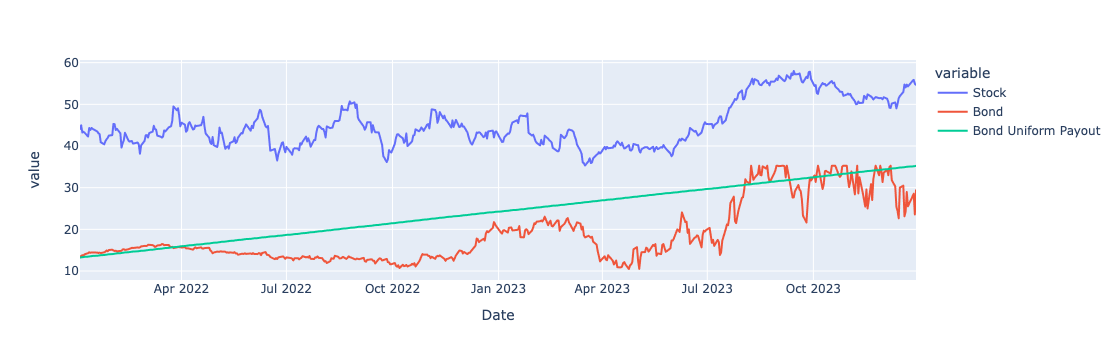

In [4]:
np.random.seed(1234567890)

stock_mean = np.mean(df["Stock"])
stock_variance = np.var(df["Stock"])
stock_std = np.std(df["Stock"])

def decay_factor(date):
    days_to_maturity = (MATURITY_DATE - date).days
    decay = np.exp(-0.005 * days_to_maturity)  # Exponential decay factor
    return decay

bond_prices = []
prev_move = bond_purchase_price
for index, row in df.iterrows():
    date = row["Date"]
    decay = decay_factor(date)
    fluctuation = np.random.normal(0, stock_std) * decay 
    price = prev_move + fluctuation
    bond_price = min(price, bond_purchase_price + bond_net_payout)
    prev_move = bond_price
    bond_prices.append(bond_price)

df["Bond"] = bond_prices
px.line(df, x="Date", y=["Stock", "Bond", "Bond Uniform Payout"])

In [5]:
# Equity Risk
TICKER_SP = "^GSPC"
start = "2022-01-04"
end = "2023-12-28"

sp500_data = yf.download(TICKER_SP, start=start, end=end)
df["S&P 500"] = sp500_data["Close"] / np.mean(sp500_data["Close"])


# Interest Rate Risk
TICKER_TREASURY = "^IRX"  # 13-week Treasury bill yield
treasury_yield_curve_data = yf.download(TICKER_TREASURY, start=start, end=end)
df["Treasury"] = treasury_yield_curve_data["Close"] / np.mean(treasury_yield_curve_data["Close"])


# Credit Risk (debt / equity ratio)
# (2023, 0.24)	(2022, 0.32) from https://stockanalysis.com/stocks/crc/financials/ratios/
np.random.seed(1234)
n = stock_data.shape[0]
m = (0.24 - 0.32) / float(n)
b = 0.32
y_values = np.array([ (m * x) + b + np.random.normal(0, 0.006) for x in range(n)])
y_values = y_values / np.mean(y_values)
df["Debt/Equity Ratio"] = y_values

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
px.line(df, x="Date", y=["S&P 500", "Treasury", "Debt/Equity Ratio"])

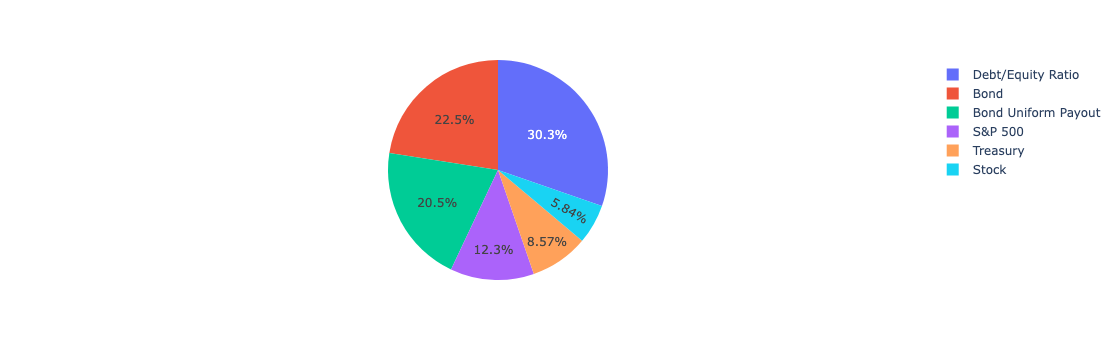

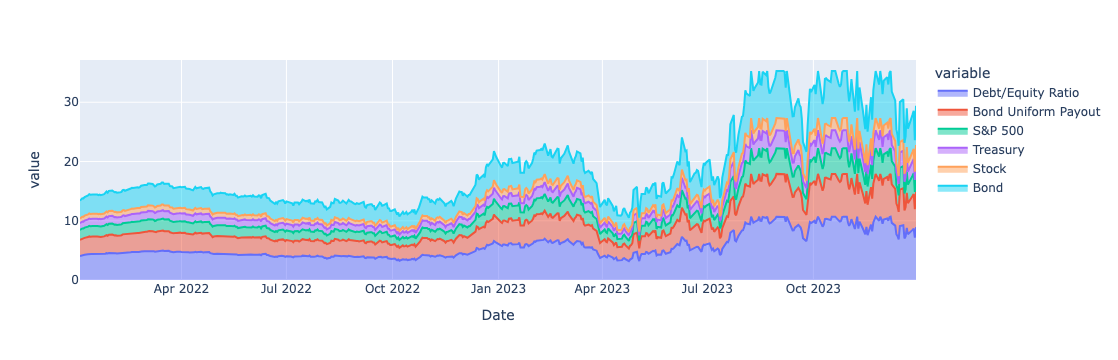

In [6]:
# Ridge Regression

X = sm.add_constant(df[["Stock", "Bond Uniform Payout", "S&P 500", "Treasury", "Debt/Equity Ratio"]])
X = X.fillna(X.mean())
model = sm.OLS(df["Bond"], X).fit_regularized(alpha=0.5, L1_wt=0)

param_names = list(model.model.exog_names)
param_values = list(model.params)

param_abs_values = [abs(float(v)) for v in param_values]
param_value_total = float(sum(param_abs_values))
param_proportion = [v/param_value_total for v in param_abs_values]

key_value = [(param_names[i], param_proportion[i]) for i in range(len(param_names))]
key_value.sort(key=lambda x: x[1], reverse=True)
const = float([x[1] for x in key_value if x[0] == "const"][0])
key_value = [x for x in key_value if x[0] != "const"]
key_value.append(["Bond", const])

df_pie = pd.DataFrame()
df_pie["Name"] = [x[0] for x in key_value]
df_pie["Value"] = [x[1] for x in key_value]
px.pie(df_pie, values="Value", names="Name").show()


proportion_total = np.zeros(df.shape[0])

df_final = pd.DataFrame()
df_final["Date"] = df["Date"]
df_final["Bond"] = df["Bond"]

for name, proportion in key_value:
    value = (df_final["Bond"] * proportion)
    df_final[name] = value

y_labels = [x[0] for x in key_value]
px.area(df_final, x="Date", y=y_labels)

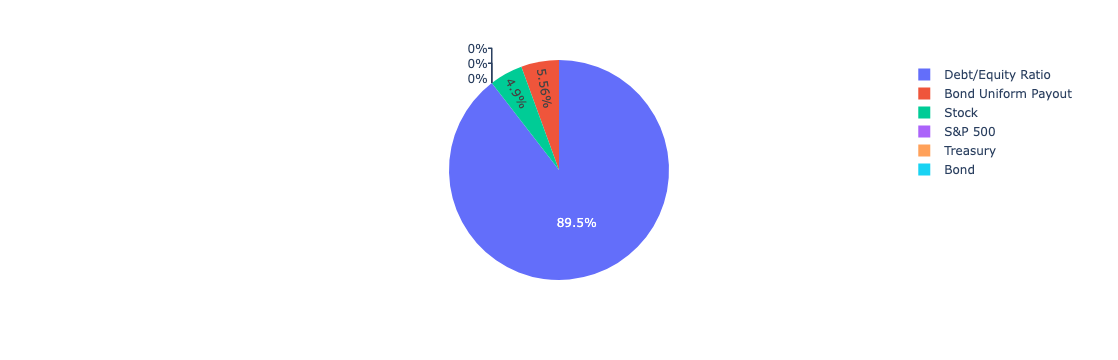

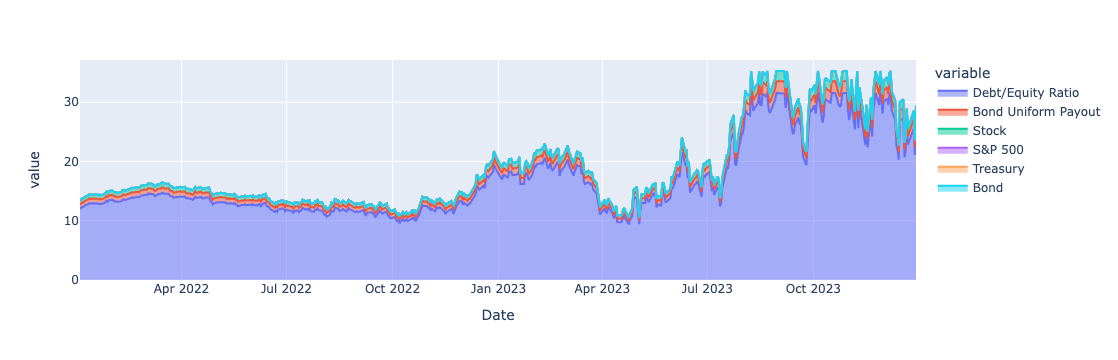

In [7]:
# Lasso Regression

X = sm.add_constant(df[["Stock", "Bond Uniform Payout", "S&P 500", "Treasury", "Debt/Equity Ratio"]])
X = X.fillna(X.mean())
model = sm.OLS(df["Bond"], X).fit_regularized(alpha=0.5, L1_wt=1)

param_names = list(model.model.exog_names)
param_values = list(model.params)
param_abs_values = [abs(float(v)) for v in param_values]
param_value_total = float(sum(param_abs_values))
param_proportion = [v/param_value_total for v in param_abs_values]

key_value = [(param_names[i], param_proportion[i]) for i in range(len(param_names))]
key_value.sort(key=lambda x: x[1], reverse=True)
const = float([x[1] for x in key_value if x[0] == "const"][0])
key_value = [x for x in key_value if x[0] != "const"]
key_value.append(["Bond", const])

df_pie = pd.DataFrame()
df_pie["Name"] = [x[0] for x in key_value]
df_pie["Value"] = [x[1] for x in key_value]
px.pie(df_pie, values="Value", names="Name").show()


proportion_total = np.zeros(df.shape[0])

df_final = pd.DataFrame()
df_final["Date"] = df["Date"]
df_final["Bond"] = df["Bond"]

for name, proportion in key_value:
    value = (df_final["Bond"] * proportion)
    df_final[name] = value

y_labels = [x[0] for x in key_value]
px.area(df_final, x="Date", y=y_labels)

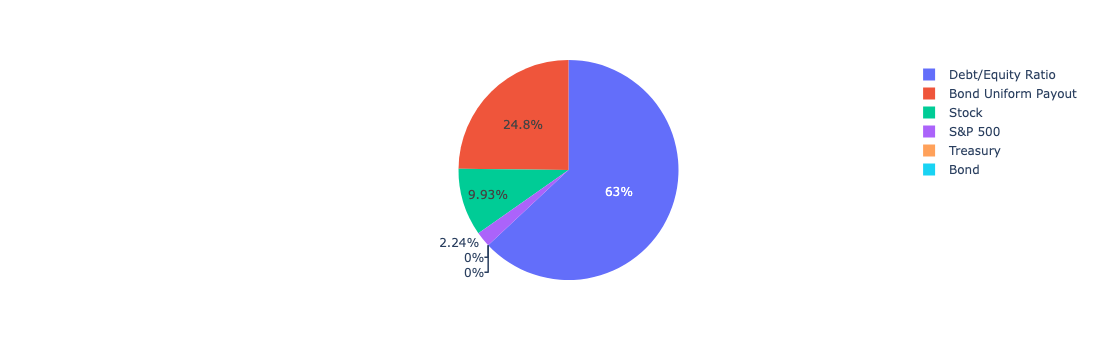

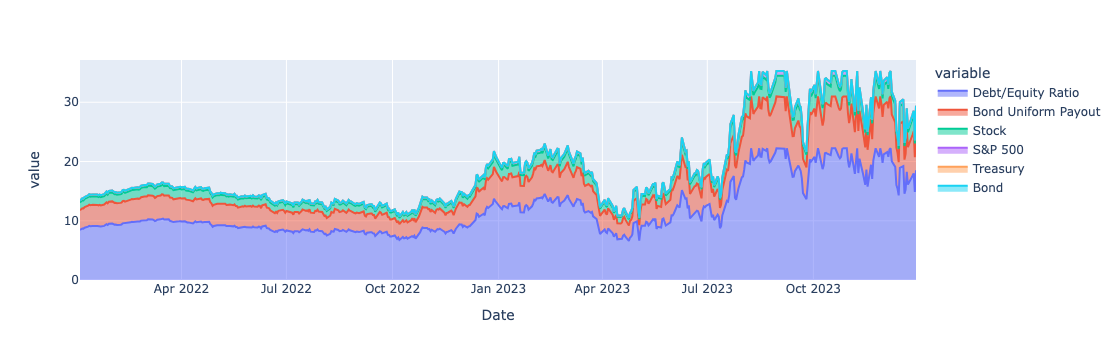

In [8]:
# Elastic Net Regression

X = sm.add_constant(df[["Stock", "Bond Uniform Payout", "S&P 500", "Treasury", "Debt/Equity Ratio"]])
X = X.fillna(X.mean())
model = sm.OLS(df["Bond"], X).fit_regularized(alpha=0.5, L1_wt=0.5)

param_names = list(model.model.exog_names)
param_values = list(model.params)
param_abs_values = [abs(float(v)) for v in param_values]
param_value_total = float(sum(param_abs_values))
param_proportion = [v/param_value_total for v in param_abs_values]

key_value = [(param_names[i], param_proportion[i]) for i in range(len(param_names))]
key_value.sort(key=lambda x: x[1], reverse=True)
const = float([x[1] for x in key_value if x[0] == "const"][0])
key_value = [x for x in key_value if x[0] != "const"]
key_value.append(["Bond", const])

df_pie = pd.DataFrame()
df_pie["Name"] = [x[0] for x in key_value]
df_pie["Value"] = [x[1] for x in key_value]
px.pie(df_pie, values="Value", names="Name").show()
proportion_total = np.zeros(df.shape[0])

df_final = pd.DataFrame()
df_final["Date"] = df["Date"]
df_final["Bond"] = df["Bond"]

for name, proportion in key_value:
    value = (df_final["Bond"] * proportion)
    df_final[name] = value

y_labels = [x[0] for x in key_value]
px.area(df_final, x="Date", y=y_labels)